# Mixtec Gender Classification

### Imports

In [17]:
%matplotlib inline
# %pip install pandas numpy torcheval torch matplotlib
import os

from pathlib import Path
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split, ConcatDataset
from torchvision import datasets, transforms

from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

from torch.utils.data.sampler import WeightedRandomSampler

torch.manual_seed(42)

### Install weights and biases

In [2]:
# Install weights and biases
%pip install wandb -qqq
import wandb
%env "WANDB_NOTEBOOK_NAME" "mixtec-gender-classification"
wandb.login()

Note: you may need to restart the kernel to use updated packages.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="mixtec-gender-classification"


wandb: Currently logged in as: cegme. Use `wandb login --relogin` to force relogin


True

### Define hardware

In [3]:
!pwd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

/orange/ufdatastudios/alexwebber/mixteclabeling/notebooks
Using device: cuda


NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Define path to images

In [4]:
basepath = Path('/home/alexwebber/toorange/alexwebber/mixteclabeling') # Base data directory
path_v = basepath / 'data/labeled_figures/codex_vindobonensis/gender/'
path_n = basepath / 'data/labeled_figures/codex_nuttall/gender/'
path_s = basepath / 'data/labeled_figures/codex_selden/gender/'

### Load figures into pandas, visualize

In [5]:
# Random Block Transform
class AddRandomBlockNoise(torch.nn.Module):
    def __init__(self, n_k=8, size=64):
        super(AddRandomBlockNoise, self).__init__()
        self.n_k = int(n_k * np.random.rand()) # Random number of boxes
        self.size = int(size * np.random.rand()) # Max size
    
    def forward(self, tensor):
        h, w = self.size, self.size
        img = np.asarray(tensor)
        img_size_x = img.shape[1]
        img_size_y = img.shape[2]
        boxes = []
        for k in range(self.n_k):
            if (img_size_y >= h or img_size_x >=w): break
            print(f"{h=} {w=} {img_size_x=} {img_size_y=}")
            x = np.random.randint(0, img_size_x-w, 1)[0] # FIXME the shape may be zero
            y = np.random.randint(0, img_size_y-h, 1)[0]
            img[:, y:y+h, x:x+w] = 0
            boxes.append((x,y,h,w))
        #img = Image.fromarray(img.astype('uint8'), 'RGB')
        return torch.from_numpy(img)
    
    def __repr__(self):
        return self.__class__.__name__ + '(blocks={0}, size={1})'.format(self.n_k, self.size)

In [6]:
## Load CSV
mixtec_figures = pd.read_csv(basepath / "data/mixtec_figures.csv")

print(mixtec_figures.groupby('quality')['gender'].value_counts())
print('\n')
print(mixtec_figures['gender'].value_counts())
print('\n')
print(mixtec_figures['quality'].value_counts())


quality  gender
a        male      427
         female    220
b        male       68
         female     47
c        female      8
         male        4
Name: count, dtype: int64


gender
male      499
female    275
Name: count, dtype: int64


quality
a    647
b    115
c     12
Name: count, dtype: int64


### Load figures into datasets by codex

In [15]:
## Define image transforms
## List of transforms https://pytorch.org/vision/stable/auto_examples/plot_transforms.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     AddRandomBlockNoise(),
     transforms.Resize((227, 227), antialias=True),
     # transforms.Grayscale(),
     
     #transforms.ColorJitter(contrast=0.5),
     #transforms.RandomRotation(360),     # Maybe useful for standng and sitting
     #transforms.RandomHorizontalFlip(50),
     #transforms.RandomVerticalFlip(50)
])

## Load images into PyTorch dataset
vindobonensis_dataset = datasets.ImageFolder(path_v, transform=transform)
nuttall_dataset = datasets.ImageFolder(path_n, transform=transform)
selden_dataset = datasets.ImageFolder(path_s, transform=transform)

Dataset ImageFolder
    Number of datapoints: 210
    Root location: /home/alexwebber/toorange/alexwebber/mixteclabeling/data/labeled_figures/codex_vindobonensis/gender
    StandardTransform
Transform: Compose(
               ToTensor()
               AddRandomBlockNoise(blocks=7, size=14)
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
           )


### Concatenate datasets

In [19]:
figures_dataset = ConcatDataset([vindobonensis_dataset, nuttall_dataset, selden_dataset])

print(figures_dataset)

### Assign classes to map

In [7]:
class_map = {0: "female", 1: "male"}

### Print random image for sanity check

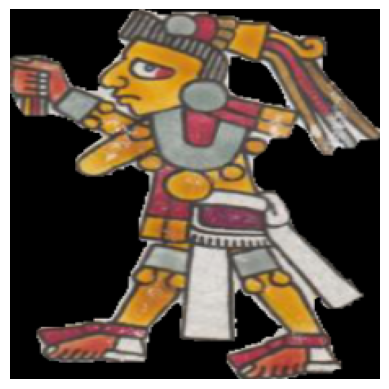

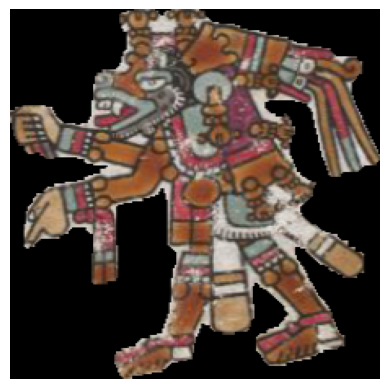

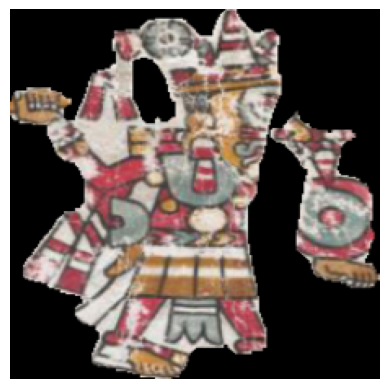

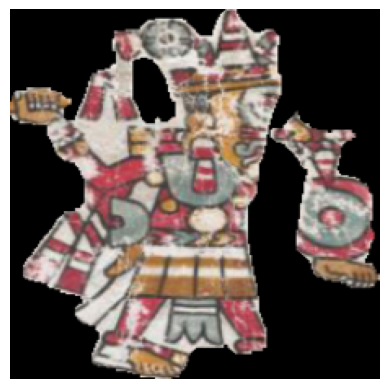

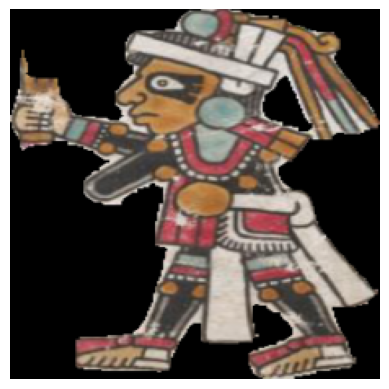

In [8]:
# Access a random image from the dataset

for i in range(5):
    random_index = np.random.randint(len(figures_dataset))
    image, label = figures_dataset[random_index]

    # Convert the image tensor to a NumPy array and transpose it
    image = image.permute(1, 2, 0)
    image = image.numpy()

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Visualize dataloaders

In [9]:
def count_classes(dataset, n_classes=2):
    image_count = [0]*(n_classes)
    for img in dataset:
        image_count[img[1]] += 1
    return image_count

def sampler_(dataset, n_classes=2):
    dataset_counts = count_classes(dataset)
    num_samples = len(dataset_counts)
    labels = [tag for _,tag in dataset]

    class_weights = [num_samples/dataset_counts[i] for i in range(n_classes)]
    weights = [class_weights[labels[i]] for i in range(num_samples)]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=True)
    return sampler

### Split combined dataset into training and testing sets and load into DataLoaders

In [10]:
batch_size = 128

train_set, test_set = random_split(figures_dataset, [0.8, 0.2])

sampler = sampler_(train_set.dataset)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size,  shuffle = True)

# Training

### Define CNN

In [28]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(16 * 56 * 56, 1568)  # Adjusted size
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.dropout1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1, 16 * 56 * 56)
        
        x = self.dropout2(x)
        x = self.fc1(x)
        x = x.view(batch_size, -1)
        return x


# Create the model
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)

### Define hyperparameters

In [29]:
lossweight = torch.tensor([1.5,1.0]).to(device)
#lossweight.to(device)
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.NLLLoss()
#optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(cnn.parameters())

In [13]:
# data = train_loader

### Train model

In [14]:
%%wandb

run = wandb.init(project="mixtec-gender-classification",
           config={
               "batch_size": batch_size,
               "learning_rate": 0.001,
#               "dataset": "CIFAR-100",
               "epoch": 50
           })

wandb.watch(cnn)
cnn.train()



for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    losses = []
    
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        losses.append(loss.item())
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent or adam step
        optimizer.step()

        # print statistics
        
        if i % batch_size == 0:
            print("Epoch: " + str(epoch + 1) + " | " "Loss: " + str(running_loss))
        
            running_loss = 0.0
        
        wandb.log({"loss": loss.item()})

print('Finished Training')

run.finish()



Epoch: 1 | Loss: 7.987143039703369
Epoch: 2 | Loss: 0.8433577418327332
Epoch: 3 | Loss: 0.7880990505218506
Epoch: 4 | Loss: 0.3661079406738281
Epoch: 5 | Loss: 0.3752446472644806
Epoch: 6 | Loss: 0.5284163951873779
Epoch: 7 | Loss: 0.37494727969169617
Epoch: 8 | Loss: 0.35395124554634094
Epoch: 9 | Loss: 0.36719608306884766
Epoch: 10 | Loss: 0.2594988942146301
Epoch: 11 | Loss: 0.27023589611053467
Epoch: 12 | Loss: 0.372961163520813
Epoch: 13 | Loss: 0.3045633137226105
Epoch: 14 | Loss: 0.21437498927116394
Epoch: 15 | Loss: 0.17875848710536957
Epoch: 16 | Loss: 0.19408725202083588
Epoch: 17 | Loss: 0.14351718127727509
Epoch: 18 | Loss: 0.13189806044101715
Epoch: 19 | Loss: 0.12955786287784576
Epoch: 20 | Loss: 0.10728783905506134
Epoch: 21 | Loss: 0.09766189008951187
Epoch: 22 | Loss: 0.0835428237915039
Epoch: 23 | Loss: 0.09322454780340195
Epoch: 24 | Loss: 0.06375891715288162
Epoch: 25 | Loss: 0.05464038625359535
Epoch: 26 | Loss: 0.042940735816955566
Epoch: 27 | Loss: 0.035325914621

loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00234


### View incorrectly labeled samples

In [15]:
cnn.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [16]:
for i, data in enumerate(train_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    
    outputs = cnn(images)
    
    _, predictions = torch.max(outputs, 1)
    
    correct = 0
    total = len(predictions)
    for label, image, prediction in zip(labels, images, predictions):
        if label != prediction:
            image = image.permute(1, 2, 0)
            image = image.cpu().numpy()

            plt.imshow(image)
            plt.title("Prediction: " + class_map[prediction.item()] + " | Label: " + class_map[label.item()])
            plt.axis('off')
            plt.show()


            

### Save model

In [17]:
savepath = "../models/mixtec_gender_classifier.pth"

torch.save(cnn.state_dict(), savepath)

### Visualize learning

In [18]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mixtec_experiment_gender')

### Define tensorboard output function

In [19]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize1
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="inferno")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Output sample heatmap of selected features

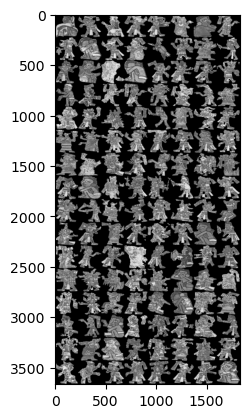

In [20]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('mixtec_genders', img_grid)

# Testing

### Load images and labels from test_loader

In [21]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

### Load model

In [22]:
cnn = CNN()
cnn.load_state_dict(torch.load(savepath))
cnn.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1568, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)

### Produce predictions and calculate accuracy of model

In [23]:
cnn.eval()

predicted_list = []
target_list = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        target_list += labels.cpu()
        
        # calculate outputs by running images through the network
        outputs = cnn(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        print(_)
        predicted_list += predicted
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {str(len(test_set))} test images: {100 * correct // total} %')

tensor([27.1970, 22.0426, 19.1774, 23.4260, 21.2984, 20.4667, 24.8345, 22.6836,
        21.3968, 21.2802, 24.3754, 24.3097, 21.6205, 25.6569, 26.6992, 20.7498,
        23.3764, 22.8933, 20.3378, 24.0448, 19.5204, 22.1558, 25.1557, 22.7865,
        23.0958, 21.2115, 23.9793, 19.7403, 22.9815, 15.4687, 16.2976, 19.0311,
        19.8004, 24.1844, 23.3526, 23.2571, 24.4643, 23.7760, 23.9698, 24.2409,
        21.8681, 24.0822], device='cuda:0')
Accuracy of the network on the 42 test images: 85 %


In [24]:
print(f"Predicted: {torch.tensor(predicted_list)}")
print(f"Truth    : {torch.tensor(target_list)}")

metric_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics = [BinaryAccuracy(), BinaryPrecision(), BinaryRecall(), BinaryF1Score()]

for metric, name in zip(metrics, metric_names):
    metric.update(torch.tensor(predicted_list), torch.tensor(target_list))
    print(f"{name:<9}: {metric.compute()}")

Predicted: tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
Truth    : tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
Accuracy : 0.8571428656578064
Precision: 0.8529411554336548
Recall   : 0.9666666388511658
F1       : 0.90625
